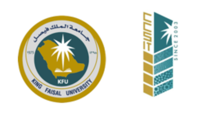


<h1><center>
King Faisal University <br>
College of Computer Sciences and Information Technology <br>
CS324: Artificial Intelligence – Project 
</h1>



<strong>
<center>[0921 - 324]: [Artificial Intelligence]
<br><br>
<center>Section: [Male/Female]
<br><br><br><br>

<center>Lab Project: [Used Cars Price Prediction System]
<br><br><br><br>

<center>Team members: [Rana Aljabr, Maathir Alshehab, Shuaa Alrajeh]
<br><br><br><br>


<center> Date: [13/May/2022]
<center> Time: [22:00]
<br><br>


<center> Instructor: Ms. Nura Aljaafari
</strong>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso,  LassoCV
from sklearn.model_selection import GridSearchCV

1. Data Pre-processing: Removal of unnecassary values and type handeling

In [2]:
train_data = pd.read_csv("train-data.csv")

In [3]:
# drop unnecassary column(new price) 
train_data.drop(columns = ['Unnamed: 0', 'New_Price'], inplace = True)

In [4]:
# Dropping rows that contain null value 
train_data = train_data.dropna(axis=0) 

In [5]:
#keep only name of manufacturing company
first_name = list(train_data.Name)
for i in range(len(first_name)):
    first_name[i] = first_name[i].split(' ', 1)[0]

train_data.Name = first_name

#solve duplicate name with sensitive case
train_data['Name'] = train_data['Name'].str.upper() 

In [6]:
# remove units
def remove_unit(array,c = None):
    for i in range(len(c)):
        array[c[i]] = array[c[i]].str.split().str[0]
    
remove_unit(train_data, c =['Mileage','Engine','Power'])

In [7]:
#power column has null values so we delete containg null then change to float 
train_data.drop(train_data[train_data['Power'] == 'null' ].index, inplace = True)

# changing datatype from string to float
for col in ['Mileage','Engine', 'Kilometers_Driven',"Price","Power"]:
    train_data[col] = train_data[col].astype(float)

2. Exploratory Analysis 

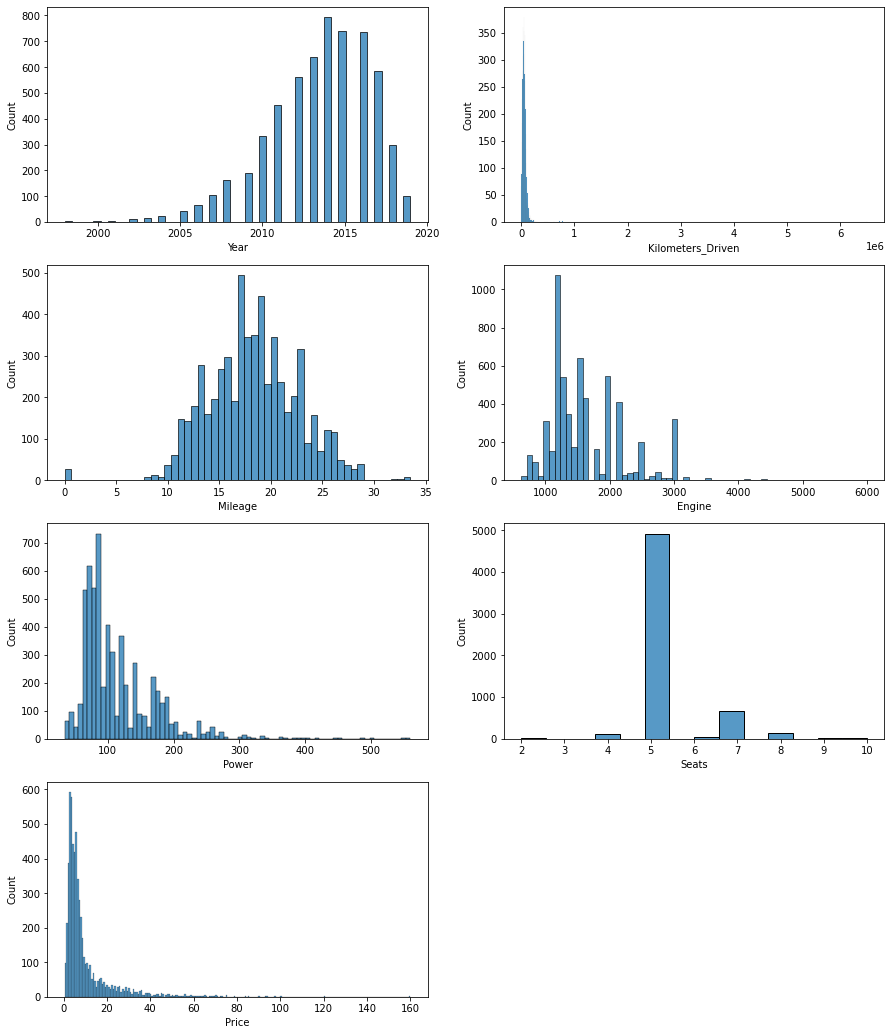

In [8]:
#split data to numerical and categorical for easier visualization
numerical_cols = ["Year","Kilometers_Driven","Mileage","Engine","Power","Seats","Price"]
cat_cols = ["Name", "Location", "Fuel_Type", "Transmission", "Owner_Type" ]


plt.figure(figsize=(15,10))
for j,i in enumerate(numerical_cols):
    plt.subplots_adjust(top=1.5)
    plt.subplot(4,2,j+1)
    sns.histplot(train_data[i])

- Most of the year data lies between 2014 􏰘 2017
- No car reached 1*10^6 Km all cars range up until 800,000
- Mileage on cars sold mainly range from 13 to 27 km very little amount has more or
less than that
- Most engines are of 1500 CC
- Power varies widely but most cars range from 50 to 100 bhp
3
- Cars normally have 5 seats with exceptions of 2,4,6,7, 8, 9, and 10
- price of all used cars is less than or equal to 100k$

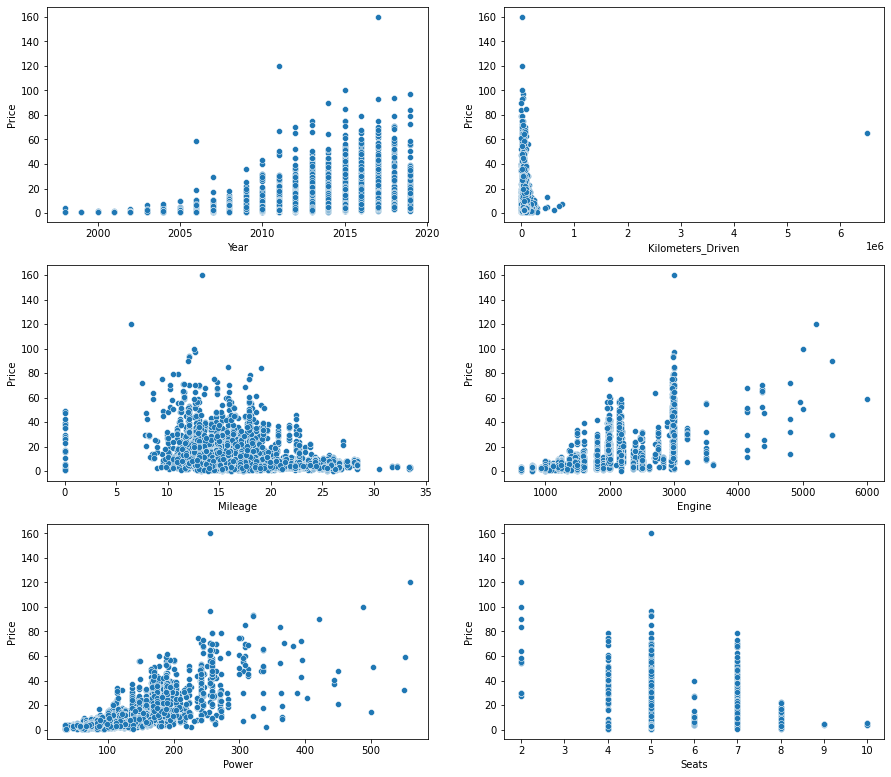

In [9]:
# price compared to attributes
plt.figure(figsize=(15, 10))

for j,i in enumerate(numerical_cols[:6]):
    plt.subplots_adjust(top=1.5)
    plt.subplot(4,2,j+1)
    sns.scatterplot(y=train_data['Price'], x=train_data[i])

- Newer cars are higher in price
- As more kilometers driven, price tend to drop lower
- Mileage is tightly scattered around the center and there is not a direct relation to price
- No relation clear between engine and price
- The higher the power, the more expensive the car is
- 9 and 10 seat cars have the cheapest price
- 5,7, and 2 seat cars have the highest market price

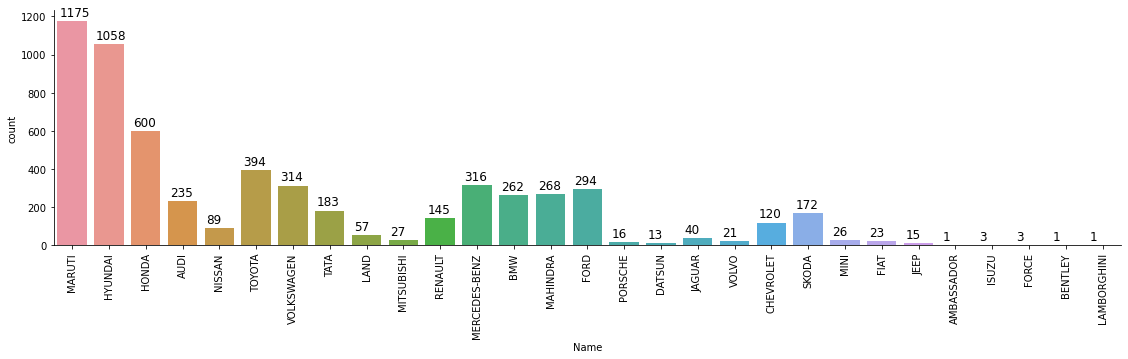

In [10]:
#car company count
g= sns.catplot(x="Name", kind="count", height = 4, aspect=4, data=train_data);

plt.xticks(rotation=90);
ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.05, 
            p.get_height() + 25, 
            p.get_height(),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

- Most used cars sold are Maruti
- Korean, Japanese, and Chinese car brands are sold more often

3. Data Pre-processing: Categorical encoding and feature scaling

In [11]:
# convert seats an year to categorical values(improves performance) 
train_data['Year'] = pd.Categorical(train_data['Year'])
train_data['Seats'] = pd.Categorical(train_data['Seats'])
# convert categorical values to dummy/indicator values
train_data = pd.get_dummies(train_data, prefix_sep='_', drop_first=True)    

In [12]:
#normalize data for training and testing 
out =  train_data[["Price"]].to_numpy() #return a numpy array 
train_data = train_data.drop(columns = ["Price"]) #its what we want to predict 

In [13]:
#feature scaling
feature_scaled = MinMaxScaler().fit_transform( train_data.values )
train_data = pd.DataFrame(feature_scaled)
#splitting data to train and test data 
X = train_data.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, out, train_size=0.70, test_size=0.30, random_state=1)

4. Implementation of Regression Models using gridsearchCV and Model Evaluation

In [14]:
# 1. Linear Regression
LR_param = { 'fit_intercept': [True,False] , 'normalize': [True,False], 'copy_X': [True,False] , 'n_jobs':[2,4] } 
LR_model = GridSearchCV(LinearRegression(), LR_param)
LR_model.fit(X_train, y_train)
LR_predict = LR_model.predict(X_test)
# model evaluation : r2 score, mean squared error(MSE), mean absolute error(MAE)
print("Linear Regression:")
print('R2 Score = {:.2f}'.format(metrics.r2_score(y_test, LR_predict )))
print("MSE = {:.2f}".format( mean_squared_error(y_test, LR_predict)) )
print("MAE = {:.2f}".format( metrics.mean_absolute_error(y_test, LR_predict)) )

Linear Regression:
R2 Score = 0.80
MSE = 24.35
MAE = 2.87


In [15]:
# 2. Random Forest Regressor 
RF_param = {'n_estimators': [50,100,150], 'random_state': [2,4]}
RF_model = GridSearchCV(RandomForestRegressor(), RF_param)
RF_model.fit(X_train, np.ravel(y_train))
RF_predict = RF_model.predict(X_test)
#model evaluation : r2 score, mean squared error(MSE), mean absolute error(MAE)
print("Random Forest Regression:")
print('R2 score = {:0.2f}'.format(metrics.r2_score(y_test, RF_predict)))
print("MSE = {:.2f}".format( mean_squared_error(y_test, RF_predict)) ) 
print("MAE = {:.2f}".format( metrics.mean_absolute_error(y_test, RF_predict)) )

Random Forest Regression:
R2 score = 0.90
MSE = 12.66
MAE = 1.68


In [16]:
# 3. Extreme gradient boosting regressor 
XGB_param = {'n_estimators': [50,100,150], 'learning_rate':[0.01,0.02], 'n_jobs':[2,4]}
XGB = GridSearchCV(XGBRegressor() , XGB_param )
XGB.fit(X_train, y_train)
XGB_predict = XGB.predict(X_test)
#model evaluation : r2 score, mean squared error(MSE), mean absolute error(MAE)
print("XGB Regressor:")
print('R2 Score = {:0.2f}'.format(metrics.r2_score(y_test, XGB_predict)))
print("MSE = {:.2f}".format( mean_squared_error(y_test, XGB_predict)) ) 
print("MAE = {:.2f}".format( metrics.mean_absolute_error(y_test, XGB_predict )) )

XGB Regressor:
R2 Score = 0.86
MSE = 16.60
MAE = 2.10


In [17]:
#4. Lasso regressor
lasso_param = {'alpha':[0.02, 0.03, 0.01, 0.04]}
lasso_model = GridSearchCV(Lasso(), lasso_param)
lasso_model.fit(X_train,y_train)
lasso_predict = lasso_model.predict(X_test)
#model evaluation : r2 score, mean squared error(MSE), mean absolute error(MAE)
print("Lasso Regressor:")
print('R2 Score = {:0.2f}'.format(metrics.r2_score(y_test, lasso_predict)))
print("MSE = {:.2f}".format( mean_squared_error(y_test, lasso_predict)) ) 
print("MAE = {:.2f}".format( metrics.mean_absolute_error(y_test, lasso_predict)) )

Lasso Regressor:
R2 Score = 0.79
MSE = 25.49
MAE = 2.92


finally, we conclude that Random forest regressor gives the best predection and should be used for this problem 